# EDA Notebook

* Author: Finian O'Neill
* Purpose: Perform exploratory data analysis on each dataset provided by Kaggle for the "Predict Podcast Listening Time" competition.

### Setup

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from scipy import stats

# Set style for better visualizations
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [2]:
def value_counts_with_percentage(df, column_name):
    """
    Outputs a dataframe with both the value counts and percentage for a given column.
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe
    column_name : str
        Name of the categorical column to process
        
    Returns:
    --------
    result : pandas DataFrame
        DataFrame with the value counts and percentage
    """
    # get value counts
    counts = df[column_name].value_counts()
    
    # calculate percentages
    percentages = df[column_name].value_counts(normalize=True) * 100
    
    # combine into a DataFrame
    result = pd.DataFrame({
        'Count': counts,
        'Percentage': percentages.round(2)
    })
    
    # add % symbol to percentage column
    result['Percentage'] = result['Percentage'].astype(str) + '%'
    
    return result

In [3]:
def cluster_similar_categories(df, column_name, n_clusters=None, similarity_threshold=0.7):
    """
    Groups semantically similar categories using text similarity and clustering
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe
    column_name : str
        Name of the categorical column to process
    n_clusters : int, optional
        Number of clusters to create. If None, determined automatically
    similarity_threshold : float, optional
        Threshold for considering categories similar in automatic mode
        
    Returns:
    --------
    df_copy : pandas DataFrame
        DataFrame with the new clustered column
    mapping : dict
        Mapping from original categories to cluster labels
    """
    df_copy = df.copy()
    
    # Get unique categories
    categories = df[column_name].dropna().unique().tolist()
    
    # If very few categories, no need to cluster
    if len(categories) <= 5:
        print(f"Only {len(categories)} categories found. No clustering needed.")
        return df_copy, {cat: cat for cat in categories}
    
    # Convert categories to strings
    categories = [str(cat) for cat in categories]
    
    # Create TF-IDF vectors for the categories
    vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 4))
    tfidf_matrix = vectorizer.fit_transform(categories)
    
    # Calculate similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    # Determine number of clusters if not provided
    if n_clusters is None:
        # Use elbow method or silhouette score
        distortions = []
        K_range = range(1, min(15, len(categories)))
        for k in K_range:
            kmeans = KMeans(n_clusters=k, random_state=42)
            kmeans.fit(tfidf_matrix)
            distortions.append(kmeans.inertia_)
        
        # Find "elbow" point - simple heuristic
        deltas = np.diff(distortions)
        n_clusters = np.argmax(deltas) + 1
        n_clusters = max(n_clusters, 2)  # At least 2 clusters
        
        # Plot elbow curve
        plt.figure(figsize=(10, 6))
        plt.plot(K_range, distortions, 'bx-')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        plt.title('Elbow Method For Optimal Clusters')
        plt.axvline(x=n_clusters, color='r', linestyle='--')
        plt.show()
        
        print(f"Auto-selected {n_clusters} clusters based on elbow method")
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(tfidf_matrix)
    
    # Create mapping from original categories to cluster labels
    mapping = {}
    cluster_groups = defaultdict(list)
    
    for cat, label in zip(categories, cluster_labels):
        cluster_groups[label].append(cat)
    
    # Create meaningful names for clusters
    for label, members in cluster_groups.items():
        if len(members) == 1:
            # If only one member, keep original name
            cluster_name = members[0]
        else:
            # Find most frequent or representative member
            counts = df[df[column_name].isin(members)][column_name].value_counts()
            most_common = counts.index[0] if not counts.empty else members[0]
            cluster_name = f"{most_common}_cluster_{label}"
        
        # Map all members to this cluster name
        for member in members:
            mapping[member] = cluster_name
    
    # Apply mapping to create new column
    new_col_name = f"{column_name}_clustered"
    df_copy[new_col_name] = df_copy[column_name].astype(str).map(mapping)
    df_copy[new_col_name] = df_copy[new_col_name].fillna('other')
    
    # Print cluster statistics
    original_count = len(categories)
    new_count = len(set(mapping.values()))
    print(f"Reduced cardinality from {original_count} to {new_count} categories")
    
    # Print samples from each cluster to verify semantic similarity
    print("\nSample clusters:")
    for label, members in list(cluster_groups.items())[:5]:  # Show first 5 clusters
        print(f"Cluster {label}: {', '.join(members[:5])}" + 
              (f" ... and {len(members)-5} more" if len(members) > 5 else ""))
    
    return df_copy, mapping

# Example usage:
# df_clustered, category_mapping = cluster_similar_categories(train_df, 'high_cardinality_column', n_clusters=10)

# Then you can use any encoding method on the reduced categories
# For example, with one-hot encoding:
# df_encoded = pd.get_dummies(df_clustered, columns=['high_cardinality_column_clustered'])

In [4]:
# function to perform EDA based on data type
def perform_eda(df):
    print(f"Dataset Shape: {df.shape}")
    print("\nData Types:")
    print(df.dtypes)
    
    # Basic statistics
    print("\nBasic Statistics:")
    print(df.describe().T)
    
    # Missing values analysis
    print("\nMissing Values Analysis:")
    missing = df.isnull().sum()
    missing_percent = 100 * missing / len(df)
    missing_data = pd.DataFrame({
        'Missing Count': missing,
        'Missing Percentage': missing_percent.round(2)
    })
    print(missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Count', ascending=False))
    
    # Create a folder for saving plots if it doesn't exist
    import os
    if not os.path.exists('eda_plots'):
        os.makedirs('eda_plots')
    
    # Identify numeric and categorical columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns
    
    # Analysis for numeric columns
    print(f"\nAnalyzing {len(numeric_cols)} numeric features...")
    
    # Correlation analysis
    plt.figure(figsize=(14, 10))
    correlation = df[numeric_cols].corr()
    mask = np.triu(np.ones_like(correlation, dtype=bool))
    sns.heatmap(correlation, mask=mask, annot=False, cmap='coolwarm', 
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Correlation Matrix', fontsize=15)
    plt.tight_layout()
    plt.savefig('eda_plots/correlation_matrix.png')
    plt.close()
    
    # Distributions of numeric features
    for i, column in enumerate(numeric_cols):
        plt.figure(figsize=(12, 6))
        
        # Create subplot with 1 row and 2 columns
        plt.subplot(1, 2, 1)
        sns.histplot(df[column].dropna(), kde=True)
        plt.title(f'Distribution of {column}')
        
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[column].dropna())
        plt.title(f'Boxplot of {column}')
        
        plt.tight_layout()
        plt.savefig(f'eda_plots/numeric_{column}.png')
        plt.close()
        
        # Basic statistics for the column
        stats_data = df[column].describe()
        skewness = df[column].skew()
        kurtosis = df[column].kurt()
        
        print(f"\nFeature: {column}")
        print(f"Min: {stats_data['min']:.2f}")
        print(f"Max: {stats_data['max']:.2f}")
        print(f"Mean: {stats_data['mean']:.2f}")
        print(f"Median: {stats_data['50%']:.2f}")
        print(f"Std Dev: {stats_data['std']:.2f}")
        print(f"Skewness: {skewness:.2f}")
        print(f"Kurtosis: {kurtosis:.2f}")
        
        # Check for outliers using IQR method
        Q1 = stats_data['25%']
        Q3 = stats_data['75%']
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
        print(f"Number of outliers: {len(outliers)}")
        print(f"Percentage of outliers: {(len(outliers)/len(df))*100:.2f}%")
        
    # Analysis for categorical columns
    print(f"\nAnalyzing {len(categorical_cols)} categorical features...")
    for column in categorical_cols:
        plt.figure(figsize=(12, 6))
        
        # Value counts
        value_counts = df[column].value_counts()
        value_percentages = 100 * df[column].value_counts(normalize=True).round(2)
        
        print(f"\nFeature: {column}")
        print(f"Number of unique values: {df[column].nunique()}")
        print(f"Most common value: {value_counts.index[0]} (Count: {value_counts.iloc[0]}, {value_percentages.iloc[0]}%)")
        
        # If too many categories, limit to top 20
        if df[column].nunique() > 20:
            print(f"Top 20 categories:")
            for i, (val, count) in enumerate(value_counts.iloc[:20].items()):
                print(f"{val}: {count} ({value_percentages.iloc[i]}%)")
            
            # Plot top 20 categories
            plt.subplot(1, 2, 1)
            sns.barplot(x=value_counts.iloc[:20].values, y=value_counts.iloc[:20].index)
            plt.title(f'Top 20 Categories in {column}')
            plt.xlabel('Count')
            
            # Plot pie chart for top 10
            plt.subplot(1, 2, 2)
            explode = [0.05] * min(10, len(value_counts))
            value_counts.iloc[:10].plot.pie(autopct='%1.1f%%', explode=explode)
            plt.title(f'Top 10 Categories in {column}')
            
        else:
            # Print all categories
            for i, (val, count) in enumerate(value_counts.items()):
                print(f"{val}: {count} ({value_percentages.iloc[i]}%)")
            
            # Bar plot
            plt.subplot(1, 2, 1)
            sns.barplot(x=value_counts.values, y=value_counts.index)
            plt.title(f'Categories in {column}')
            plt.xlabel('Count')
            
            # Pie chart
            plt.subplot(1, 2, 2)
            explode = [0.05] * len(value_counts)
            value_counts.plot.pie(autopct='%1.1f%%', explode=explode)
            plt.title(f'Distribution in {column}')
        
        plt.tight_layout()
        plt.savefig(f'eda_plots/categorical_{column}.png')
        plt.close()
    
    # Special analysis for "Episode_Title_binned" if it exists
    if 'Episode_Title_binned' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Episode_Title_binned', data=df)
        plt.title('Distribution of Episodes by Period')
        plt.xlabel('Episode Period')
        plt.ylabel('Count')
        plt.tight_layout()
        plt.savefig('eda_plots/episode_title_binned.png')
        plt.close()
        
        print("\nEpisode Title Binned Distribution:")
        episode_counts = df['Episode_Title_binned'].value_counts()
        episode_percentages = 100 * df['Episode_Title_binned'].value_counts(normalize=True).round(2)
        for i, (val, count) in enumerate(episode_counts.items()):
            print(f"{val}: {count} ({episode_percentages.iloc[i]}%)")
    
    print("\nEDA completed! Plots saved in 'eda_plots' folder.")

### Data Import

In [5]:
# load train dataset and expect
train_df = pd.read_csv('data/train.csv')
train_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [6]:
# print the describe
train_df.describe()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,750000.000000,662907.000000,750000.000000,603970.000000,749999.000000,750000.000000
mean,374999.500000,64.504738,59.859901,52.236449,1.348855,45.437406
std,216506.495284,32.969603,22.873098,28.451241,1.151130,27.138306
min,0.000000,0.000000,1.300000,0.000000,0.000000,0.000000
25%,187499.750000,35.730000,39.410000,28.380000,0.000000,23.178350
50%,374999.500000,63.840000,60.050000,53.580000,1.000000,43.379460
75%,562499.250000,94.070000,79.530000,76.600000,2.000000,64.811580
max,749999.000000,325.240000,119.460000,119.910000,103.910000,119.970000


In [7]:
# define categorical and numerical columns
numerical_columns = ['Episode_Length_minutes', 'Host_Popularity_percentage', 
                    'Guest_Popularity_percentage', 'Number_of_Ads', 
                    'Listening_Time_minutes']

exclude_columns = ['id']

# get categorical columns by filtering out numerical columns
categorical_columns = [col for col in train_df.columns if (col not in numerical_columns) and (col not in exclude_columns)]

In [8]:
# print values in categorical columns
for col in categorical_columns:
    print('Currently displaying the values in the column {col}...'.format(col=col))
    print('There are a total of {n} unique categories in this column...'.format(n=len(train_df[col].value_counts())))
    print(value_counts_with_percentage(df=train_df, column_name=col))
    print('-' * 50)

Currently displaying the values in the column Podcast_Name...
There are a total of 48 unique categories in this column...
                     Count Percentage
Podcast_Name                         
Tech Talks           22847      3.05%
Sports Weekly        20053      2.67%
Funny Folks          19635      2.62%
Tech Trends          19549      2.61%
Fitness First        19488       2.6%
Business Insights    19480       2.6%
Style Guide          19364      2.58%
Game Day             19272      2.57%
Melody Mix           18889      2.52%
Criminal Minds       17735      2.36%
Finance Focus        17628      2.35%
Detective Diaries    17452      2.33%
Crime Chronicles     17374      2.32%
Athlete's Arena      17327      2.31%
Fashion Forward      17280       2.3%
Tune Time            17254       2.3%
Business Briefs      17012      2.27%
Lifestyle Lounge     16661      2.22%
True Crime Stories   16373      2.18%
Sports Central       16191      2.16%
Digital Digest       16171      2.16%
Humo

#### Observations in Regards to Categorical Columns:

* 1) **Podcast_Name** --> This feature has 48 different categories and the most frequently appearing category only comprises ~3% of the observations. This particular feature likely should be encoded using either: frequency encoding or clustering similar categories based on semantics to reduce the dimensionality.
* 2) **Episode_Title** --> This feature appears to just be the numerical ordering of the episode in regards to where it falls in the podcast series (for example "Episode 71"). The individual episode numbers may not have any meaning however this feature likely would benefit from being binned with the hypothesis that episodes could be bucketed into: "Early in Series"; "Mid in Series"; "Later in Series".
* 3) **Genre** --> There are 10 unique categories within this feature. Moreover, the distribution of records by category seems some what even. The best approach would likely be to one-hot encode this feature.
* 4) **Publication_Day** --> There are 7 unique categories within this feature (each day of the week). Moreover, the distribution of records by category seems some what even. The best approach would likely be to one-hot encode this feature.
* 5) **Publication_Time** --> There are 4 unique categories within this feature. Moreover, the distribution of records by category seems some what even. The best approach would likely be to one-hot encode this feature.
* 6) **Episode_Sentiment** --> There are 3 unique categories within this feature. However, there seems to be a natural ordinality to the features (Negative ; Neutral ; Positive). The best approach would probably be to use the following encoding mapping: {Negative: -1, Neutral: 0, Positive: 1}

### Prelim Feature Engineering

#### 1) Podcast_Name

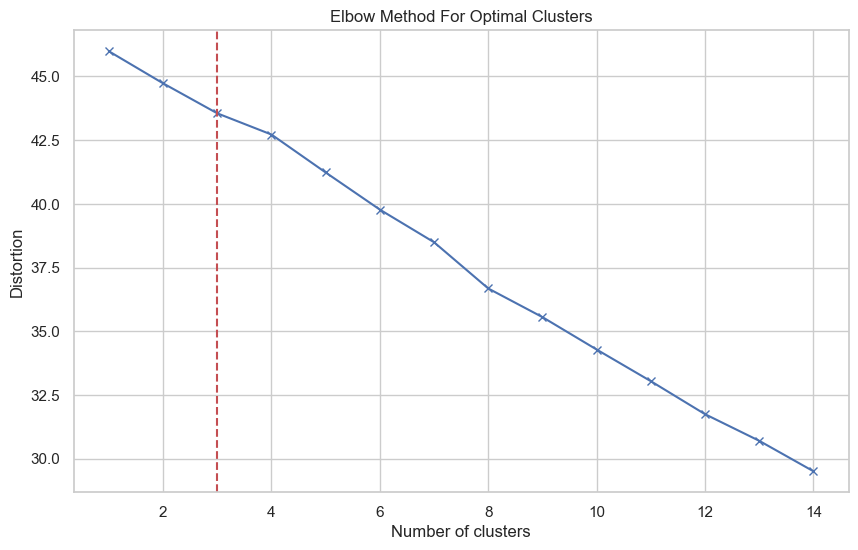

Auto-selected 3 clusters based on elbow method
Reduced cardinality from 48 to 3 categories

Sample clusters:
Cluster 0: Mystery Matters, Joke Junction, Music Matters, Melody Mix, Game Day ... and 14 more
Cluster 1: Study Sessions, Digital Digest, Mind & Body, Fitness First, Criminal Minds ... and 14 more
Cluster 2: News Roundup, Global News, Tech Trends, Health Hour, Sound Waves ... and 5 more


In [9]:
# go through example of clustering the Podcast_Name
train_clustered_df, podcast_name_cluster_map = cluster_similar_categories(df=train_df, column_name='Podcast_Name')

In [10]:
# post the clustering the clusters can then be one-hot encoded since there are only 3
train_encoded_df = pd.get_dummies(train_clustered_df, columns=['Podcast_Name_clustered'])
train_encoded_df.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False


In [11]:
# drop the no longer needed 'Podcast_Name' column
train_encoded_df = train_encoded_df.drop(columns=['Podcast_Name'])
train_encoded_df.head()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2
0,0,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False
1,1,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False
2,2,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False
3,3,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False
4,4,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False


#### 2) Episode_Title

In [12]:
# for the episode title, display the sorted range of values
print(sorted(list(train_encoded_df['Episode_Title'].unique())))

['Episode 1', 'Episode 10', 'Episode 100', 'Episode 11', 'Episode 12', 'Episode 13', 'Episode 14', 'Episode 15', 'Episode 16', 'Episode 17', 'Episode 18', 'Episode 19', 'Episode 2', 'Episode 20', 'Episode 21', 'Episode 22', 'Episode 23', 'Episode 24', 'Episode 25', 'Episode 26', 'Episode 27', 'Episode 28', 'Episode 29', 'Episode 3', 'Episode 30', 'Episode 31', 'Episode 32', 'Episode 33', 'Episode 34', 'Episode 35', 'Episode 36', 'Episode 37', 'Episode 38', 'Episode 39', 'Episode 4', 'Episode 40', 'Episode 41', 'Episode 42', 'Episode 43', 'Episode 44', 'Episode 45', 'Episode 46', 'Episode 47', 'Episode 48', 'Episode 49', 'Episode 5', 'Episode 50', 'Episode 51', 'Episode 52', 'Episode 53', 'Episode 54', 'Episode 55', 'Episode 56', 'Episode 57', 'Episode 58', 'Episode 59', 'Episode 6', 'Episode 60', 'Episode 61', 'Episode 62', 'Episode 63', 'Episode 64', 'Episode 65', 'Episode 66', 'Episode 67', 'Episode 68', 'Episode 69', 'Episode 7', 'Episode 70', 'Episode 71', 'Episode 72', 'Episode 73

In [13]:
# from this list, it seems like episodes range from 1 to 100. I will simplify assumptions and just bin
# as the following for each podcast
# early --> 1 - 33
# mid --> 34 - 66
# late --> 67 - 100
early_list = ['Episode {counter}'.format(counter=n + 1) for n in range(100) if n + 1 <= 33]
mid_list = ['Episode {counter}'.format(counter=n + 1) for n in range(100) if (n + 1 > 33) and (n + 1 <= 66)]
late_list = ['Episode {counter}'.format(counter=n + 1) for n in range(100) if (n + 1 > 66) and (n + 1 <= 100)]

# create episode dict
episode_map = {}
# add early entries
for i in range(len(early_list)):
    episode_map[early_list[i]] = 'early'
# add mid entries
for j in range(len(mid_list)):
    episode_map[mid_list[j]] = 'mid'
# add late entries
for k in range(len(late_list)):
    episode_map[late_list[k]] = 'late'
    
print(episode_map)

{'Episode 1': 'early', 'Episode 2': 'early', 'Episode 3': 'early', 'Episode 4': 'early', 'Episode 5': 'early', 'Episode 6': 'early', 'Episode 7': 'early', 'Episode 8': 'early', 'Episode 9': 'early', 'Episode 10': 'early', 'Episode 11': 'early', 'Episode 12': 'early', 'Episode 13': 'early', 'Episode 14': 'early', 'Episode 15': 'early', 'Episode 16': 'early', 'Episode 17': 'early', 'Episode 18': 'early', 'Episode 19': 'early', 'Episode 20': 'early', 'Episode 21': 'early', 'Episode 22': 'early', 'Episode 23': 'early', 'Episode 24': 'early', 'Episode 25': 'early', 'Episode 26': 'early', 'Episode 27': 'early', 'Episode 28': 'early', 'Episode 29': 'early', 'Episode 30': 'early', 'Episode 31': 'early', 'Episode 32': 'early', 'Episode 33': 'early', 'Episode 34': 'mid', 'Episode 35': 'mid', 'Episode 36': 'mid', 'Episode 37': 'mid', 'Episode 38': 'mid', 'Episode 39': 'mid', 'Episode 40': 'mid', 'Episode 41': 'mid', 'Episode 42': 'mid', 'Episode 43': 'mid', 'Episode 44': 'mid', 'Episode 45': 'mid

In [14]:
# bin the actual 'Episode_Title' column
train_encoded_df['Episode_Title_binned'] = train_encoded_df['Episode_Title'].map(episode_map).fillna('unknown')
train_encoded_df.head()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned
0,0,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False,late
1,1,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False,early
2,2,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False,early
3,3,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False,mid
4,4,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False,late


In [15]:
# now one hot encode the binned values
train_encoded_df = pd.get_dummies(train_encoded_df, columns=['Episode_Title_binned'])
train_encoded_df.head()

,id,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned_early,Episode_Title_binned_late,Episode_Title_binned_mid
0,0,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False,False,True,False
1,1,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False,True,False,False
2,2,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False,True,False,False
3,3,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False,False,False,True
4,4,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False,False,True,False


In [16]:
# drop the no longer needed 'Episode_Title' column
train_encoded_df = train_encoded_df.drop(columns=['Episode_Title'])
train_encoded_df.head()

,id,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned_early,Episode_Title_binned_late,Episode_Title_binned_mid
0,0,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,True,False,False,True,False
1,1,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,True,False,True,False,False
2,2,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,False,False,True,False,False
3,3,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,False,False,False,False,True
4,4,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,False,False,False,True,False


#### 3) Genre

In [17]:
# one-hot encode the Genre since there are only 10 categories
train_encoded_df = pd.get_dummies(train_encoded_df, columns=['Genre'])
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,...,Genre_Business,Genre_Comedy,Genre_Education,Genre_Health,Genre_Lifestyle,Genre_Music,Genre_News,Genre_Sports,Genre_Technology,Genre_True Crime
0,0,NaN,74.81,Thursday,Night,NaN,0.0,Positive,31.41998,False,...,False,False,False,False,False,False,False,False,False,True
1,1,119.80,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,False,...,False,True,False,False,False,False,False,False,False,False
2,2,73.90,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,True,...,False,False,True,False,False,False,False,False,False,False
3,3,67.17,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,True,...,False,False,False,False,False,False,False,False,True,False
4,4,110.51,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,True,...,False,False,False,True,False,False,False,False,False,False


#### 4) Publication_Day

In [18]:
# one-hot encode the Publication_Day since there are only 7 categories
train_encoded_df = pd.get_dummies(train_encoded_df, columns=['Publication_Day'])
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,...,Genre_Sports,Genre_Technology,Genre_True Crime,Publication_Day_Friday,Publication_Day_Monday,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday
0,0,NaN,74.81,Night,NaN,0.0,Positive,31.41998,False,True,...,False,False,True,False,False,False,False,True,False,False
1,1,119.80,66.95,Afternoon,75.95,2.0,Negative,88.01241,False,True,...,False,False,False,False,False,True,False,False,False,False
2,2,73.90,69.97,Evening,8.97,0.0,Negative,44.92531,True,False,...,False,False,False,False,False,False,False,False,True,False
3,3,67.17,57.22,Morning,78.70,2.0,Positive,46.27824,True,False,...,False,True,False,False,True,False,False,False,False,False
4,4,110.51,80.07,Afternoon,58.68,3.0,Neutral,75.61031,True,False,...,False,False,False,False,True,False,False,False,False,False


#### 5) Publication_Time

In [19]:
# one-hot encode the Publication_Time since there are only 4 categories
train_encoded_df = pd.get_dummies(train_encoded_df, columns=['Publication_Time'])
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,...,Publication_Day_Monday,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night
0,0,NaN,74.81,NaN,0.0,Positive,31.41998,False,True,False,...,False,False,False,True,False,False,False,False,False,True
1,1,119.80,66.95,75.95,2.0,Negative,88.01241,False,True,False,...,False,True,False,False,False,False,True,False,False,False
2,2,73.90,69.97,8.97,0.0,Negative,44.92531,True,False,False,...,False,False,False,False,True,False,False,True,False,False
3,3,67.17,57.22,78.70,2.0,Positive,46.27824,True,False,False,...,True,False,False,False,False,False,False,False,True,False
4,4,110.51,80.07,58.68,3.0,Neutral,75.61031,True,False,False,...,True,False,False,False,False,False,True,False,False,False


#### 6) Episode_Sentiment

In [20]:
# for the sentiment map to values to ascribe ordinality
episode_sentiment_map = {
    'Negative': -1,
    'Neutral': 0,
    'Positive': 1
}

train_encoded_df['Episode_Sentiment_mapped'] = train_encoded_df['Episode_Sentiment'].map(episode_sentiment_map)
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,...,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_mapped
0,0,NaN,74.81,NaN,0.0,Positive,31.41998,False,True,False,...,False,False,True,False,False,False,False,False,True,1
1,1,119.80,66.95,75.95,2.0,Negative,88.01241,False,True,False,...,True,False,False,False,False,True,False,False,False,-1
2,2,73.90,69.97,8.97,0.0,Negative,44.92531,True,False,False,...,False,False,False,True,False,False,True,False,False,-1
3,3,67.17,57.22,78.70,2.0,Positive,46.27824,True,False,False,...,False,False,False,False,False,False,False,True,False,1
4,4,110.51,80.07,58.68,3.0,Neutral,75.61031,True,False,False,...,False,False,False,False,False,True,False,False,False,0


In [21]:
# drop the no longer needed 'Episode_Sentiment' column
train_encoded_df = train_encoded_df.drop(columns=['Episode_Sentiment'])
train_encoded_df.head()

,id,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned_early,...,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_mapped
0,0,NaN,74.81,NaN,0.0,31.41998,False,True,False,False,...,False,False,True,False,False,False,False,False,True,1
1,1,119.80,66.95,75.95,2.0,88.01241,False,True,False,True,...,True,False,False,False,False,True,False,False,False,-1
2,2,73.90,69.97,8.97,0.0,44.92531,True,False,False,True,...,False,False,False,True,False,False,True,False,False,-1
3,3,67.17,57.22,78.70,2.0,46.27824,True,False,False,False,...,False,False,False,False,False,False,False,True,False,1
4,4,110.51,80.07,58.68,3.0,75.61031,True,False,False,False,...,False,False,False,False,False,True,False,False,False,0


### Explore Distributions and Correlations

In [22]:
# drop the not needed 'id' column
train_encoded_df = train_encoded_df.drop(columns=['id'])
train_encoded_df.head()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,Podcast_Name_clustered_Sports Weekly_cluster_1,Podcast_Name_clustered_Tech Talks_cluster_0,Podcast_Name_clustered_Tech Trends_cluster_2,Episode_Title_binned_early,Episode_Title_binned_late,...,Publication_Day_Saturday,Publication_Day_Sunday,Publication_Day_Thursday,Publication_Day_Tuesday,Publication_Day_Wednesday,Publication_Time_Afternoon,Publication_Time_Evening,Publication_Time_Morning,Publication_Time_Night,Episode_Sentiment_mapped
0,NaN,74.81,NaN,0.0,31.41998,False,True,False,False,True,...,False,False,True,False,False,False,False,False,True,1
1,119.80,66.95,75.95,2.0,88.01241,False,True,False,True,False,...,True,False,False,False,False,True,False,False,False,-1
2,73.90,69.97,8.97,0.0,44.92531,True,False,False,True,False,...,False,False,False,True,False,False,True,False,False,-1
3,67.17,57.22,78.70,2.0,46.27824,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,1
4,110.51,80.07,58.68,3.0,75.61031,True,False,False,False,True,...,False,False,False,False,False,True,False,False,False,0


In [23]:
# examine null values across columns
train_encoded_df.isna().sum()

Episode_Length_minutes                             87093
Host_Popularity_percentage                             0
Guest_Popularity_percentage                       146030
Number_of_Ads                                          1
Listening_Time_minutes                                 0
Podcast_Name_clustered_Sports Weekly_cluster_1         0
Podcast_Name_clustered_Tech Talks_cluster_0            0
Podcast_Name_clustered_Tech Trends_cluster_2           0
Episode_Title_binned_early                             0
Episode_Title_binned_late                              0
Episode_Title_binned_mid                               0
Genre_Business                                         0
Genre_Comedy                                           0
Genre_Education                                        0
Genre_Health                                           0
Genre_Lifestyle                                        0
Genre_Music                                            0
Genre_News                     

In [24]:
round(train_encoded_df.isna().sum() / len(train_encoded_df) * 100, 2)

Episode_Length_minutes                            11.61
Host_Popularity_percentage                         0.00
Guest_Popularity_percentage                       19.47
Number_of_Ads                                      0.00
Listening_Time_minutes                             0.00
Podcast_Name_clustered_Sports Weekly_cluster_1     0.00
Podcast_Name_clustered_Tech Talks_cluster_0        0.00
Podcast_Name_clustered_Tech Trends_cluster_2       0.00
Episode_Title_binned_early                         0.00
Episode_Title_binned_late                          0.00
Episode_Title_binned_mid                           0.00
Genre_Business                                     0.00
Genre_Comedy                                       0.00
Genre_Education                                    0.00
Genre_Health                                       0.00
Genre_Lifestyle                                    0.00
Genre_Music                                        0.00
Genre_News                                      

In [25]:
# run the full EDA on the encoded dataset
perform_eda(train_encoded_df)

Dataset Shape: (750000, 33)

Data Types:
Episode_Length_minutes                            float64
Host_Popularity_percentage                        float64
Guest_Popularity_percentage                       float64
Number_of_Ads                                     float64
Listening_Time_minutes                            float64
Podcast_Name_clustered_Sports Weekly_cluster_1       bool
Podcast_Name_clustered_Tech Talks_cluster_0          bool
Podcast_Name_clustered_Tech Trends_cluster_2         bool
Episode_Title_binned_early                           bool
Episode_Title_binned_late                            bool
Episode_Title_binned_mid                             bool
Genre_Business                                       bool
Genre_Comedy                                         bool
Genre_Education                                      bool
Genre_Health                                         bool
Genre_Lifestyle                                      bool
Genre_Music                    


Feature: Publication_Time_Morning
Number of unique values: 2
Most common value: False (Count: 572087, 76.0%)
False: 572087 (76.0%)
True: 177913 (24.0%)

Feature: Publication_Time_Night
Number of unique values: 2
Most common value: False (Count: 553151, 74.0%)
False: 553151 (74.0%)
True: 196849 (26.0%)

EDA completed! Plots saved in 'eda_plots' folder.
